# Machine Learning Models on the IDS 2018

In this notebook, deicision tree and random forest based machine learning algorithms are applied
to the ids2018 dataset. Several methods for resolving the class imbalance are tested. Decision
tree algorithms were chosen for their effectiveness and the training time which were better than
other machine learning models. RT and RF based algorithms performed better in the preliminary
experiments


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix, recall_score, f1_score, roc_auc_score
from notebook_utils import load_sample_dataset_2018
%matplotlib inline
%load_ext autoreload
%autoreload 2

file_path = r"..\CIC-IDS-2018\Processed Traffic Data for ML Algorithms"

attack_labels = {
    0: 'Benign',
    1: 'Bot',
    2: 'Brute Force -Web',
    3: 'Brute Force -XSS',
    4: 'DDOS attack-HOIC',
    5: 'DDOS attack-LOIC-UDP',
    6: 'DDoS attacks-LOIC-HTTP',
    7: 'DoS attacks-GoldenEye',
    8: 'DoS attacks-Hulk',
    9: 'DoS attacks-SlowHTTPTest',
    10: 'DoS attacks-Slowloris',
    11: 'FTP-BruteForce',
    12: 'Infilteration',
    13: 'SQL Injection',
    14: 'SSH-Bruteforce'
}

df = load_sample_dataset_2018(file_path)

Processed 1/10 files.
Processed 2/10 files.
Processed 3/10 files.
Processed 4/10 files.
Processed 5/10 files.
Processed 6/10 files.
Processed 7/10 files.
Processed 8/10 files.
Processed 9/10 files.
Processed 10/10 files.
Creating is_attack column...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623303 entries, 0 to 1623302
Data columns (total 81 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   dst_port           1623295 non-null  float64 
 1   protocol           1623295 non-null  float64 
 2   timestamp          0 non-null        float64 
 3   flow_duration      1623295 non-null  float64 
 4   tot_fwd_pkts       1623295 non-null  float64 
 5   tot_bwd_pkts       1623295 non-null  float64 
 6   totlen_fwd_pkts    1623295 non-null  float64 
 7   totlen_bwd_pkts    1623295 non-null  float64 
 8   fwd_pkt_len_max    1623295 non-null  float64 
 9   fwd_pkt_len_min    1623295 non-null  float64 
 10  fwd_pkt_len_mean   1

## Preparing the Dataset

### Check for invalid values

In [2]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
# Identify columns with NaN, infinity, or negative values
nan_columns = df[numeric_columns].columns[df[numeric_columns].isna().any()]
inf_columns = df[numeric_columns].columns[np.isinf(df[numeric_columns]).any()]
neg_columns = df[numeric_columns].columns[(df[numeric_columns] < 0).any()]
print("Columns with NaN values:", nan_columns.tolist())
print("Columns with infinite values:", inf_columns.tolist())
print("Columns with negative values:", neg_columns.tolist())
# Calculate the percentage of NaN, infinite, and negative values
nan_percentage = df[nan_columns].isna().mean() * 100
# nan_percentage = nan_percentage[nan_percentage > 1]
inf_percentage = df[inf_columns].map(lambda x: np.isinf(x)).mean() * 100
neg_percentage = df[neg_columns].map(lambda x: x < 0).mean() * 100
print("Percentage of NaN values in each column:\n", nan_percentage)
print("Percentage of infinite values in each column:\n", inf_percentage)
print("Percentage of negative values in each column:\n", neg_percentage)

Columns with NaN values: ['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s', 'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt', 'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg', 'fwd_seg_size_avg', 'bwd_seg_size_avg', 'fwd_byts_b_avg', 'fwd_pkts_b_avg', 'f

For negative values, 2 columns have an extremely high percentage of negative values. We choose to drop the features “init_win_bytes_forward” and “init_win_bytes_backward” as the source of the negative sign is unknown. For the rest of relevant features, the percentages of negative, infinite or are low so the rows are dropped.


In [3]:
def replace_invalid(df):
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    # Identify columns with NaN, infinite, or negative values
    nan_columns = df[numeric_columns].columns[df[numeric_columns].isna().any()]
    inf_columns = df[numeric_columns].columns[np.isinf(df[numeric_columns]).any()]
    neg_columns = df[numeric_columns].columns[(df[numeric_columns] < 0).any()]
    # Drop rows with NaN values (low percentage of NaN values)
    # df = df.dropna(subset=nan_columns)
    # Drop rows with infinite values (assuming low percentage)
    for col in inf_columns:
        df = df[np.isfinite(df[col])]
    # Drop columns with a high percentage of negative values
    columns_to_drop = ['init_fwd_win_byts', 'init_bwd_win_byts']
    df = df.drop(columns=columns_to_drop)
    # Drop rows with negative values in the remaining columns
    remaining_neg_columns = [col for col in neg_columns if col not in columns_to_drop]
    for col in remaining_neg_columns:
        df = df[df[col] >= 0]
    return df

In [4]:
df = replace_invalid(df)

In [5]:
X = df.iloc[:, 0:76]
Y = df[["label", "is_attack", "label_code"]]

X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 1613823 entries, 0 to 1250804
Data columns (total 76 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   dst_port           1613823 non-null  float64
 1   protocol           1613823 non-null  float64
 2   timestamp          0 non-null        float64
 3   flow_duration      1613823 non-null  float64
 4   tot_fwd_pkts       1613823 non-null  float64
 5   tot_bwd_pkts       1613823 non-null  float64
 6   totlen_fwd_pkts    1613823 non-null  float64
 7   totlen_bwd_pkts    1613823 non-null  float64
 8   fwd_pkt_len_max    1613823 non-null  float64
 9   fwd_pkt_len_min    1613823 non-null  float64
 10  fwd_pkt_len_mean   1613823 non-null  float64
 11  fwd_pkt_len_std    1613823 non-null  float64
 12  bwd_pkt_len_max    1613823 non-null  float64
 13  bwd_pkt_len_min    1613823 non-null  float64
 14  bwd_pkt_len_mean   1613823 non-null  float64
 15  bwd_pkt_len_std    1613823 non-null  

## Feature Selection

First, the columns with no variance are dropped as they have no impact on the target variables.

In [6]:
stats = X.describe()
std = stats.loc["std"]
features_no_var = std[std == 0.0].index
# Exclude non-numeric columns (e.g., categorical columns) from the features with zero variance
features_no_var_numeric = [col for col in features_no_var if col in X.select_dtypes(include=[np.number]).columns]
print(features_no_var_numeric)

['bwd_psh_flags', 'bwd_urg_flags', 'fwd_byts_b_avg', 'fwd_pkts_b_avg', 'fwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_pkts_b_avg', 'bwd_blk_rate_avg']


In [7]:
X = X.drop(columns=features_no_var)
X = X.drop(columns=['dst_port', 'timestamp'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1613823 entries, 0 to 1250804
Data columns (total 66 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   protocol           1613823 non-null  float64
 1   flow_duration      1613823 non-null  float64
 2   tot_fwd_pkts       1613823 non-null  float64
 3   tot_bwd_pkts       1613823 non-null  float64
 4   totlen_fwd_pkts    1613823 non-null  float64
 5   totlen_bwd_pkts    1613823 non-null  float64
 6   fwd_pkt_len_max    1613823 non-null  float64
 7   fwd_pkt_len_min    1613823 non-null  float64
 8   fwd_pkt_len_mean   1613823 non-null  float64
 9   fwd_pkt_len_std    1613823 non-null  float64
 10  bwd_pkt_len_max    1613823 non-null  float64
 11  bwd_pkt_len_min    1613823 non-null  float64
 12  bwd_pkt_len_mean   1613823 non-null  float64
 13  bwd_pkt_len_std    1613823 non-null  float64
 14  flow_byts_s        1613823 non-null  float64
 15  flow_pkts_s        1613823 non-null  

### Remove collinear variables

In [8]:
def correlation_feature_selection(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)
X = correlation_feature_selection(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1613823 entries, 0 to 1250804
Data columns (total 41 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   protocol          1613823 non-null  float64
 1   flow_duration     1613823 non-null  float64
 2   tot_fwd_pkts      1613823 non-null  float64
 3   tot_bwd_pkts      1613823 non-null  float64
 4   fwd_pkt_len_max   1613823 non-null  float64
 5   fwd_pkt_len_min   1613823 non-null  float64
 6   fwd_pkt_len_mean  1613823 non-null  float64
 7   bwd_pkt_len_max   1613823 non-null  float64
 8   bwd_pkt_len_min   1613823 non-null  float64
 9   bwd_pkt_len_mean  1613823 non-null  float64
 10  flow_byts_s       1613823 non-null  float64
 11  flow_pkts_s       1613823 non-null  float64
 12  flow_iat_mean     1613823 non-null  float64
 13  flow_iat_std      1613823 non-null  float64
 14  flow_iat_max      1613823 non-null  float64
 15  fwd_iat_std       1613823 non-null  float64
 16  bwd_i

### Information Gain Selection

In [9]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def oversample_minority_classes(X, Y, sample_size=1000):
    y=Y["label_code"]
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    # Create a subset of the oversampled data
    X_sample, _, y_sample, _ = train_test_split(X_resampled, y_resampled, train_size=sample_size, stratify=y_resampled, random_state=42)
    return X_sample, y_sample

def information_gain_feature_selection(X, Y, sample_size=1000):
    # Create an oversampled subset of the data
    X_sample, y_sample = oversample_minority_classes(X, Y, sample_size)
    # Create is_attack column based on label_code
    y_sample = (y_sample != 0).astype(int)
    # Perform feature selection on the oversampled subset
    info_gain = mutual_info_classif(X_sample, y_sample)
    info_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})
    info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)
    print(info_gain_df)
    selected_features = info_gain_df[info_gain_df['Information Gain'] > 0]['Feature'].tolist()
    return selected_features

# Determine the selected features using the oversampled subset
selected_features = information_gain_feature_selection(X, Y)

# Apply the selected features to the main dataset
X = X[selected_features]

# Display information about the selected features
X.info()

             Feature  Information Gain
7    bwd_pkt_len_max          0.098128
27       pkt_len_var          0.084071
4    fwd_pkt_len_max          0.079047
6   fwd_pkt_len_mean          0.075914
9   bwd_pkt_len_mean          0.064383
2       tot_fwd_pkts          0.051284
26      pkt_len_mean          0.050098
1      flow_duration          0.046261
24        bwd_pkts_s          0.045107
14      flow_iat_max          0.043121
13      flow_iat_std          0.040591
34  fwd_seg_size_min          0.040315
8    bwd_pkt_len_min          0.038632
10       flow_byts_s          0.035294
18       bwd_iat_std          0.032327
20       bwd_iat_min          0.030660
23        fwd_pkts_s          0.029708
5    fwd_pkt_len_min          0.027187
12     flow_iat_mean          0.026420
11       flow_pkts_s          0.025621
15       fwd_iat_std          0.023797
3       tot_bwd_pkts          0.022471
16       bwd_iat_tot          0.021173
25       pkt_len_min          0.019351
19       bwd_iat_max     

## Split Dataset

The dataset is split into a training set and a testing set with a ratio of 0.8/0.2. The dataset is stratified according to the label to have an equal representation of all classes in the 2 subsets.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y.label)

In [11]:
Y_train.label.value_counts()

label
Benign                      1070876
DDOS attack-HOIC              55054
DDoS attacks-LOIC-HTTP        46142
DoS attacks-Hulk              37046
Bot                           23007
FTP-BruteForce                15517
SSH-Bruteforce                15007
Infilteration                 12762
DoS attacks-SlowHTTPTest      11223
DoS attacks-GoldenEye          3372
DoS attacks-Slowloris           844
DDOS attack-LOIC-UDP            134
Brute Force -Web                 42
Brute Force -XSS                 22
SQL Injection                    10
Label                             0
Name: count, dtype: int64

In [12]:
Y_test.label.value_counts()

label
Benign                      267720
DDOS attack-HOIC             13763
DDoS attacks-LOIC-HTTP       11536
DoS attacks-Hulk              9261
Bot                           5752
FTP-BruteForce                3879
SSH-Bruteforce                3752
Infilteration                 3190
DoS attacks-SlowHTTPTest      2806
DoS attacks-GoldenEye          843
DoS attacks-Slowloris          211
DDOS attack-LOIC-UDP            34
Brute Force -Web                11
Brute Force -XSS                 5
SQL Injection                    2
Label                            0
Name: count, dtype: int64

In [13]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.0000
is_attack
0    1070876
1     220182
Name: count, dtype: int64


## Machine Learning Classifiers with Default Hyperparameters

### Helper Functions

In [14]:
import joblib

def save_model(model, model_name):
    file_path = f'models/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('models', exist_ok=True)

In [15]:
def plot_confusion_matrix(model_name, Y_true, Y_pred, labels=["Benign", "Attack"]):
    matrix = confusion_matrix(Y_true.is_attack, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def metrics_report(dataset_type, y_true, y_predict, print_avg=True):
    print(f"Classification Report ({dataset_type}):")
    print(classification_report(y_true, y_predict, digits=4))
    accuracy = accuracy_score(y_true, y_predict)
    precision = precision_score(y_true, y_predict, average='weighted')
    recall = recall_score(y_true, y_predict, average='weighted')
    f1 = f1_score(y_true, y_predict, average='weighted')
    auc = roc_auc_score(y_true, y_predict)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc": auc}

def calculate_metrics_by_label(y_true, y_pred, labels):
    results = []
    unique_labels = labels.unique()
    for label in unique_labels:
        indices = labels == label
        accuracy = accuracy_score(y_true[indices], y_pred[indices])
        results.append({
            'Label': label,
            'Accuracy': accuracy,
        })
    return pd.DataFrame(results)

In [16]:
def test_metrics(model_name, model, dataset_type, scaler):
    # Predict and evaluate on the test set
    print(f"{model_name} with {dataset_type} Test Set Performance")
    Y_pred = model.predict(scaler.transform(X_test))
    metrics = metrics_report(f"Test {model_name} ({dataset_type})", Y_test.is_attack, Y_pred)
    plot_confusion_matrix(f"{model_name} ({dataset_type})", Y_test, Y_pred)
    # Calculate metrics by label
    metrics_by_label = calculate_metrics_by_label(Y_test.is_attack, Y_pred, Y_test.label)
    metrics_by_label['Method'] = dataset_type
    print(f"Metrics by Label ({dataset_type}):")
    print(metrics_by_label)
    return metrics, metrics_by_label

In [17]:
def plot_overall_accuracy(metrics):
    methods = ['original', 'random', 'smote', 'adasyn']
    overall_accuracies = []

    # Extract overall accuracy for each method
    for method in methods:
        overall_accuracies.append(metrics[method][0]['accuracy'])

    # Plotting the overall accuracies
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, overall_accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.title('Overall Accuracy by Method')
    plt.xlabel('Method')
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1)
    plt.grid(True)

    # Display the values on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.3f}', ha='center', va='bottom')

    plt.show()

### Resampling methods

In [18]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

def resample_dataset(X, Y, min_samples, attack_labels, technique='smote'):
    Y = Y.drop(columns=['label'])
    combined = pd.concat([X, Y], axis=1)
    counts = Y['label_code'].value_counts()
    samples_number = {i: max(counts[i], min_samples) for i in np.unique(Y['label_code'])}
    combined_array = combined.values
    y_array = Y['label_code'].values

    if technique == 'random':
        resampler = RandomOverSampler(random_state=42, sampling_strategy=samples_number)
    elif technique == 'smote':
        resampler = SMOTE(random_state=42, sampling_strategy=samples_number, k_neighbors=5)
    elif technique == 'adasyn':
        resampler = ADASYN(random_state=42, sampling_strategy=samples_number)
    else:
        raise ValueError("Invalid resampling technique. Choose 'random', 'smote', or 'adasyn'.")

    resampled_array, y_resampled = resampler.fit_resample(combined_array, y_array)
    X_resampled = resampled_array[:, :-Y.shape[1]]
    Y_resampled = resampled_array[:, -Y.shape[1]:]
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    Y_resampled_df = pd.DataFrame(Y_resampled, columns=Y.columns)
    Y_resampled_df['label'] = Y_resampled_df['label_code'].map(attack_labels)
    Y_resampled_df['label'] = Y_resampled_df['label'].astype('category')
    return X_resampled_df, Y_resampled_df

In [19]:
X_random_train, Y_random_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "random")
X_smote_train, Y_smote_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "smote")
X_adasyn_train, Y_adasyn_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "adasyn")

In [20]:
Y_train.label.value_counts()

label
Benign                      1070876
DDOS attack-HOIC              55054
DDoS attacks-LOIC-HTTP        46142
DoS attacks-Hulk              37046
Bot                           23007
FTP-BruteForce                15517
SSH-Bruteforce                15007
Infilteration                 12762
DoS attacks-SlowHTTPTest      11223
DoS attacks-GoldenEye          3372
DoS attacks-Slowloris           844
DDOS attack-LOIC-UDP            134
Brute Force -Web                 42
Brute Force -XSS                 22
SQL Injection                    10
Label                             0
Name: count, dtype: int64

In [21]:
Y_random_train.label.value_counts()

label
Benign                      1070876
Bot                          100000
Brute Force -Web             100000
Brute Force -XSS             100000
DDOS attack-HOIC             100000
DDOS attack-LOIC-UDP         100000
DDoS attacks-LOIC-HTTP       100000
DoS attacks-GoldenEye        100000
DoS attacks-Hulk             100000
DoS attacks-SlowHTTPTest     100000
DoS attacks-Slowloris        100000
FTP-BruteForce               100000
Infilteration                100000
SSH-Bruteforce               100000
Name: count, dtype: int64

In [22]:
Y_smote_train.label.value_counts()

label
Benign                      1070876
Bot                          100000
Brute Force -Web             100000
Brute Force -XSS             100000
DDOS attack-HOIC             100000
DDOS attack-LOIC-UDP         100000
DDoS attacks-LOIC-HTTP       100000
DoS attacks-GoldenEye        100000
DoS attacks-Hulk             100000
DoS attacks-SlowHTTPTest     100000
DoS attacks-Slowloris        100000
FTP-BruteForce               100000
Infilteration                100000
SSH-Bruteforce               100000
Name: count, dtype: int64

In [23]:
Y_adasyn_train.label.value_counts()

label
Benign                      1070876
Infilteration                102574
DoS attacks-GoldenEye        100245
DoS attacks-Slowloris        100008
Brute Force -XSS             100006
DDoS attacks-LOIC-HTTP       100003
SSH-Bruteforce               100000
FTP-BruteForce                99999
DDOS attack-LOIC-UDP          99998
DoS attacks-SlowHTTPTest      99997
Brute Force -Web              99994
Bot                           99985
DDOS attack-HOIC              99550
DoS attacks-Hulk              98950
Name: count, dtype: int64

### Scaling with the Standard Scaler

In [24]:
# Original X_train
scaler = StandardScaler()
scaler.fit(X_train)
# Random Oversampling
scaler_random = StandardScaler()
scaler_random.fit(X_random_train)
# SMOTE
scaler_smote = StandardScaler()
scaler_smote.fit(X_smote_train)
# ADASYN
scaler_adasyn = StandardScaler()
scaler_adasyn.fit(X_adasyn_train)

StandardScaler()

### Decision Tree

In [25]:
dt_metrics = {}

In [26]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(scaler.transform(X_train), Y_train.is_attack)

DecisionTreeClassifier()

Decision Tree with Original Test Set Performance
Classification Report (Test Decision Tree (Original)):
              precision    recall  f1-score   support

           0     0.9857    0.9866    0.9861    267720
           1     0.9345    0.9303    0.9324     55045

    accuracy                         0.9770    322765
   macro avg     0.9601    0.9584    0.9593    322765
weighted avg     0.9770    0.9770    0.9770    322765

Accuracy: 0.9769925487583846
Precision: 0.9769526222247139
Recall: 0.9769925487583846
F1 Score: 0.976971567476951
AUC: 0.9584293678967986


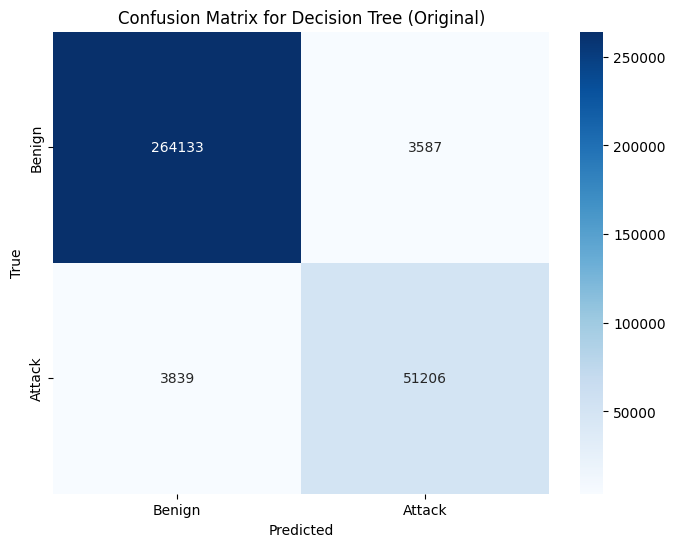

Metrics by Label (Original):
                       Label  Accuracy    Method
0                     Benign  0.986602  Original
1           DDOS attack-HOIC  0.951609  Original
2     DDoS attacks-LOIC-HTTP  0.981016  Original
3           DoS attacks-Hulk  0.995681  Original
4   DoS attacks-SlowHTTPTest  1.000000  Original
5             SSH-Bruteforce  0.999467  Original
6             FTP-BruteForce  1.000000  Original
7              Infilteration  0.101881  Original
8      DoS attacks-GoldenEye  0.998814  Original
9                        Bot  0.994958  Original
10      DDOS attack-LOIC-UDP  1.000000  Original
11     DoS attacks-Slowloris  0.962085  Original
12          Brute Force -Web  0.545455  Original
13          Brute Force -XSS  0.400000  Original
14             SQL Injection  0.500000  Original


In [27]:
# Predict and evaluate on the test set
dt_metrics["original"] = test_metrics("Decision Tree", decision_tree_model, "Original", scaler)

In [28]:
decision_tree_model_random = DecisionTreeClassifier()
decision_tree_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

DecisionTreeClassifier()

Decision Tree with Random Oversampling Test Set Performance
Classification Report (Test Decision Tree (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9881    0.9724    0.9802    267720
           1     0.8755    0.9429    0.9079     55045

    accuracy                         0.9674    322765
   macro avg     0.9318    0.9577    0.9441    322765
weighted avg     0.9689    0.9674    0.9679    322765

Accuracy: 0.9673911359657955
Precision: 0.9688707442936672
Recall: 0.9673911359657955
F1 Score: 0.9678657616700608
AUC: 0.9576710549850029


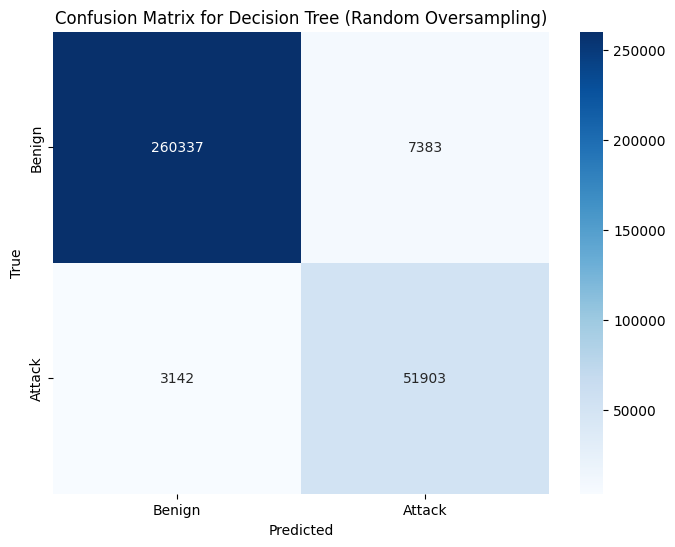

Metrics by Label (Random Oversampling):
                       Label  Accuracy               Method
0                     Benign  0.972423  Random Oversampling
1           DDOS attack-HOIC  0.967812  Random Oversampling
2     DDoS attacks-LOIC-HTTP  0.981276  Random Oversampling
3           DoS attacks-Hulk  0.997408  Random Oversampling
4   DoS attacks-SlowHTTPTest  1.000000  Random Oversampling
5             SSH-Bruteforce  0.999733  Random Oversampling
6             FTP-BruteForce  1.000000  Random Oversampling
7              Infilteration  0.239498  Random Oversampling
8      DoS attacks-GoldenEye  1.000000  Random Oversampling
9                        Bot  0.997392  Random Oversampling
10      DDOS attack-LOIC-UDP  1.000000  Random Oversampling
11     DoS attacks-Slowloris  0.952607  Random Oversampling
12          Brute Force -Web  0.545455  Random Oversampling
13          Brute Force -XSS  0.600000  Random Oversampling
14             SQL Injection  1.000000  Random Oversampling


In [29]:
# Predict and evaluate on the test set
dt_metrics["random"] = test_metrics("Decision Tree", decision_tree_model_random, "Random Oversampling", scaler_random)

In [30]:
decision_tree_model_smote = DecisionTreeClassifier()
decision_tree_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

DecisionTreeClassifier()

Decision Tree with SMOTE Test Set Performance
Classification Report (Test Decision Tree (SMOTE)):
              precision    recall  f1-score   support

           0     0.9881    0.9764    0.9822    267720
           1     0.8914    0.9428    0.9164     55045

    accuracy                         0.9707    322765
   macro avg     0.9398    0.9596    0.9493    322765
weighted avg     0.9716    0.9707    0.9710    322765

Accuracy: 0.9706566697132589
Precision: 0.9716056485978953
Recall: 0.9706566697132589
F1 Score: 0.9709798334183373
AUC: 0.9595745868222374


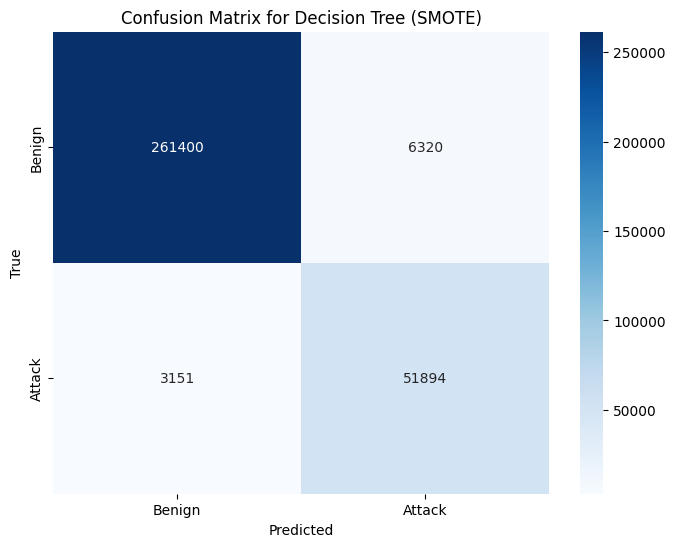

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.976393  SMOTE
1           DDOS attack-HOIC  0.963017  SMOTE
2     DDoS attacks-LOIC-HTTP  0.984310  SMOTE
3           DoS attacks-Hulk  0.996869  SMOTE
4   DoS attacks-SlowHTTPTest  1.000000  SMOTE
5             SSH-Bruteforce  0.999467  SMOTE
6             FTP-BruteForce  1.000000  SMOTE
7              Infilteration  0.247962  SMOTE
8      DoS attacks-GoldenEye  0.998814  SMOTE
9                        Bot  0.996349  SMOTE
10      DDOS attack-LOIC-UDP  1.000000  SMOTE
11     DoS attacks-Slowloris  0.981043  SMOTE
12          Brute Force -Web  0.636364  SMOTE
13          Brute Force -XSS  1.000000  SMOTE
14             SQL Injection  0.500000  SMOTE


In [31]:
# Predict and evaluate on the test set
dt_metrics["smote"] = test_metrics("Decision Tree", decision_tree_model_smote, "SMOTE", scaler_smote)

In [32]:
decision_tree_model_adasyn = DecisionTreeClassifier()
decision_tree_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

DecisionTreeClassifier()

Decision Tree with ADASYN Test Set Performance
Classification Report (Test Decision Tree (ADASYN)):
              precision    recall  f1-score   support

           0     0.9871    0.9770    0.9820    267720
           1     0.8936    0.9378    0.9152     55045

    accuracy                         0.9704    322765
   macro avg     0.9403    0.9574    0.9486    322765
weighted avg     0.9711    0.9704    0.9706    322765

Accuracy: 0.9703530432357907
Precision: 0.9711423595361217
Recall: 0.9703530432357907
F1 Score: 0.9706352716478273
AUC: 0.9574360632731159


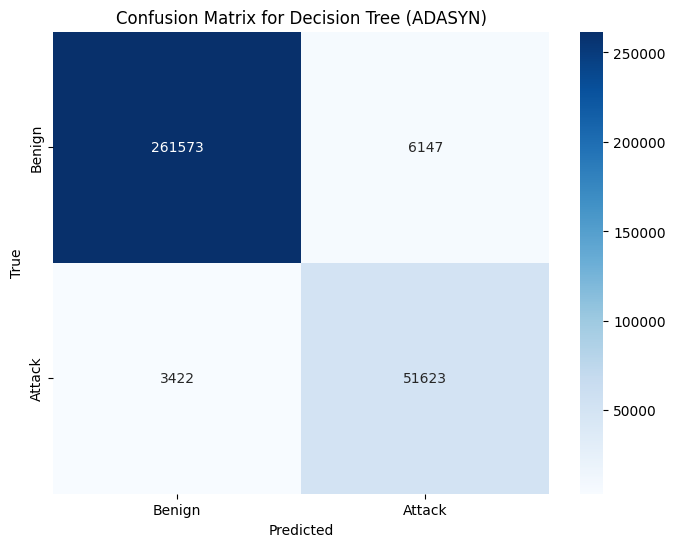

Metrics by Label (ADASYN):
                       Label  Accuracy  Method
0                     Benign  0.977039  ADASYN
1           DDOS attack-HOIC  0.965124  ADASYN
2     DDoS attacks-LOIC-HTTP  0.991505  ADASYN
3           DoS attacks-Hulk  0.997516  ADASYN
4   DoS attacks-SlowHTTPTest  1.000000  ADASYN
5             SSH-Bruteforce  0.999467  ADASYN
6             FTP-BruteForce  1.000000  ADASYN
7              Infilteration  0.124451  ADASYN
8      DoS attacks-GoldenEye  0.997628  ADASYN
9                        Bot  0.998088  ADASYN
10      DDOS attack-LOIC-UDP  1.000000  ADASYN
11     DoS attacks-Slowloris  0.971564  ADASYN
12          Brute Force -Web  0.545455  ADASYN
13          Brute Force -XSS  0.800000  ADASYN
14             SQL Injection  0.500000  ADASYN


In [33]:
# Predict and evaluate on the test set
dt_metrics["adasyn"] = test_metrics("Decision Tree", decision_tree_model_adasyn, "ADASYN", scaler_adasyn)

In [34]:
# Combine metrics into one DataFrame for Decision Tree
combined_metrics_dt = pd.concat([dt_metrics["adasyn"][1], dt_metrics["original"][1], dt_metrics["random"][1], dt_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_dt = combined_metrics_dt.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_dt = accuracy_pivot_dt[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method (Decision Tree):")
print(accuracy_pivot_dt)

Accuracy by Label and Method (Decision Tree):
Method                    Original  Random Oversampling     SMOTE    ADASYN
Label                                                                      
Benign                    0.986602             0.972423  0.976393  0.977039
Bot                       0.994958             0.997392  0.996349  0.998088
Brute Force -Web          0.545455             0.545455  0.636364  0.545455
Brute Force -XSS          0.400000             0.600000  1.000000  0.800000
DDOS attack-HOIC          0.951609             0.967812  0.963017  0.965124
DDOS attack-LOIC-UDP      1.000000             1.000000  1.000000  1.000000
DDoS attacks-LOIC-HTTP    0.981016             0.981276  0.984310  0.991505
DoS attacks-GoldenEye     0.998814             1.000000  0.998814  0.997628
DoS attacks-Hulk          0.995681             0.997408  0.996869  0.997516
DoS attacks-SlowHTTPTest  1.000000             1.000000  1.000000  1.000000
DoS attacks-Slowloris     0.962085        

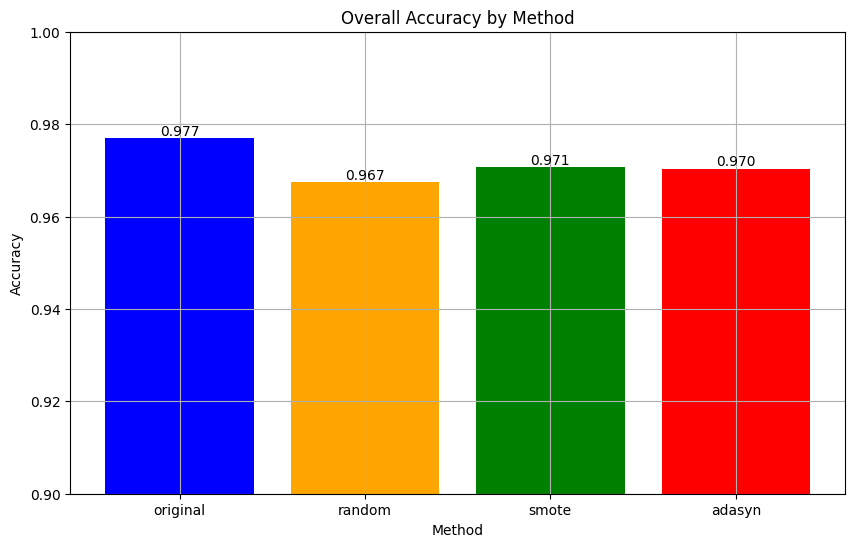

In [35]:
plot_overall_accuracy(dt_metrics)

### Random Forest

In [36]:
rf_metrics = {}

In [37]:
rf_model = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model.fit(scaler.transform(X_train), Y_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Random Forest with Original Test Set Performance


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


Classification Report (Test Random Forest (Original)):
              precision    recall  f1-score   support

           0     0.9874    0.9920    0.9897    267720
           1     0.9600    0.9383    0.9490     55045

    accuracy                         0.9828    322765
   macro avg     0.9737    0.9651    0.9693    322765
weighted avg     0.9827    0.9828    0.9827    322765

Accuracy: 0.9828110235000697
Precision: 0.9827056123070539
Recall: 0.9828110235000697
F1 Score: 0.9827328464227976
AUC: 0.9651406029773095


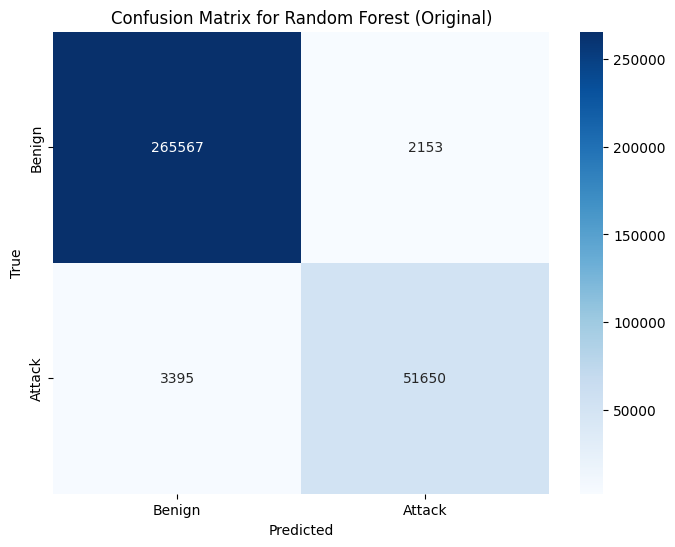

Metrics by Label (Original):
                       Label  Accuracy    Method
0                     Benign  0.991958  Original
1           DDOS attack-HOIC  0.989029  Original
2     DDoS attacks-LOIC-HTTP  0.986997  Original
3           DoS attacks-Hulk  0.998056  Original
4   DoS attacks-SlowHTTPTest  1.000000  Original
5             SSH-Bruteforce  0.999467  Original
6             FTP-BruteForce  1.000000  Original
7              Infilteration  0.044828  Original
8      DoS attacks-GoldenEye  1.000000  Original
9                        Bot  0.997914  Original
10      DDOS attack-LOIC-UDP  1.000000  Original
11     DoS attacks-Slowloris  0.971564  Original
12          Brute Force -Web  0.545455  Original
13          Brute Force -XSS  0.400000  Original
14             SQL Injection  0.500000  Original


In [38]:
# Predict and evaluate on the test set
rf_metrics["original"] = test_metrics("Random Forest", rf_model, "Original", scaler)

In [39]:
rf_model_random = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with Random Oversampling Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


Classification Report (Test Random Forest (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9897    0.9759    0.9828    267720
           1     0.8901    0.9508    0.9194     55045

    accuracy                         0.9716    322765
   macro avg     0.9399    0.9633    0.9511    322765
weighted avg     0.9727    0.9716    0.9720    322765

Accuracy: 0.9715861385218347
Precision: 0.972747152441986
Recall: 0.9715861385218347
F1 Score: 0.9719547712798587
AUC: 0.9633459288372468


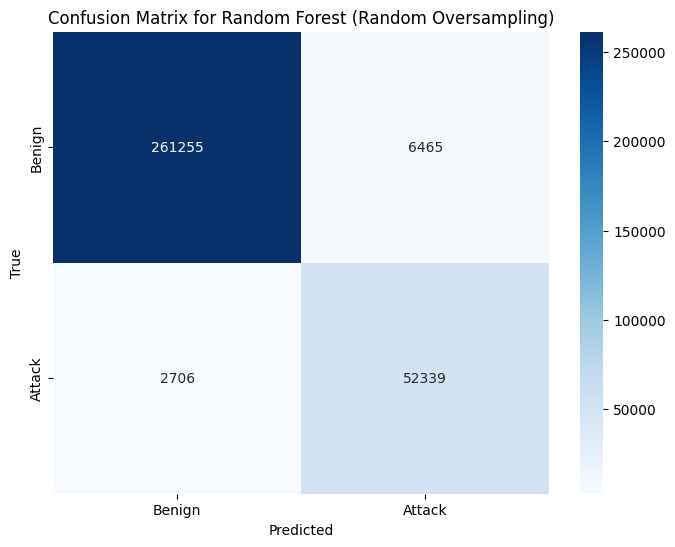

Metrics by Label (Random Oversampling):
                       Label  Accuracy               Method
0                     Benign  0.975852  Random Oversampling
1           DDOS attack-HOIC  0.993388  Random Oversampling
2     DDoS attacks-LOIC-HTTP  0.988211  Random Oversampling
3           DoS attacks-Hulk  0.998380  Random Oversampling
4   DoS attacks-SlowHTTPTest  1.000000  Random Oversampling
5             SSH-Bruteforce  0.999467  Random Oversampling
6             FTP-BruteForce  1.000000  Random Oversampling
7              Infilteration  0.232915  Random Oversampling
8      DoS attacks-GoldenEye  1.000000  Random Oversampling
9                        Bot  0.999478  Random Oversampling
10      DDOS attack-LOIC-UDP  1.000000  Random Oversampling
11     DoS attacks-Slowloris  0.976303  Random Oversampling
12          Brute Force -Web  0.545455  Random Oversampling
13          Brute Force -XSS  0.600000  Random Oversampling
14             SQL Injection  1.000000  Random Oversampling


In [40]:
# Predict and evaluate on the test set
rf_metrics["random"] = test_metrics("Random Forest", rf_model_random, "Random Oversampling", scaler_random)

In [41]:
rf_model_smote = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with SMOTE Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished


Classification Report (Test Random Forest (SMOTE)):
              precision    recall  f1-score   support

           0     0.9900    0.9737    0.9818    267720
           1     0.8817    0.9524    0.9157     55045

    accuracy                         0.9701    322765
   macro avg     0.9359    0.9630    0.9488    322765
weighted avg     0.9716    0.9701    0.9705    322765

Accuracy: 0.9700896937400276
Precision: 0.9715696425576648
Recall: 0.9700896937400276
F1 Score: 0.9705414989103793
AUC: 0.9630499987398763


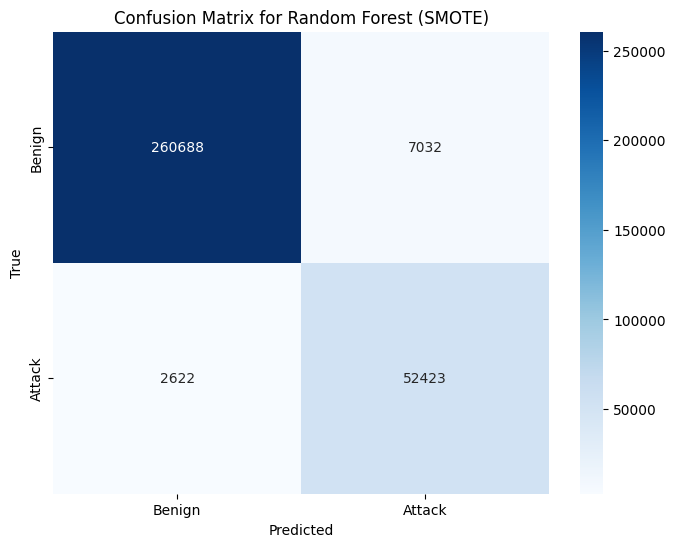

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.973734  SMOTE
1           DDOS attack-HOIC  0.994623  SMOTE
2     DDoS attacks-LOIC-HTTP  0.989511  SMOTE
3           DoS attacks-Hulk  0.998596  SMOTE
4   DoS attacks-SlowHTTPTest  1.000000  SMOTE
5             SSH-Bruteforce  0.999467  SMOTE
6             FTP-BruteForce  1.000000  SMOTE
7              Infilteration  0.247962  SMOTE
8      DoS attacks-GoldenEye  1.000000  SMOTE
9                        Bot  0.999478  SMOTE
10      DDOS attack-LOIC-UDP  1.000000  SMOTE
11     DoS attacks-Slowloris  0.981043  SMOTE
12          Brute Force -Web  0.727273  SMOTE
13          Brute Force -XSS  0.600000  SMOTE
14             SQL Injection  0.500000  SMOTE


In [42]:
# Predict and evaluate on the test set
rf_metrics["smote"] = test_metrics("Random Forest", rf_model_smote, "SMOTE", scaler_smote)

In [43]:
rf_model_adasyn = RandomForestClassifier(verbose=1, n_jobs=-1)
rf_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

Random Forest with ADASYN Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished


Classification Report (Test Random Forest (ADASYN)):
              precision    recall  f1-score   support

           0     0.9889    0.9315    0.9593    267720
           1     0.7402    0.9490    0.8317     55045

    accuracy                         0.9345    322765
   macro avg     0.8646    0.9403    0.8955    322765
weighted avg     0.9465    0.9345    0.9376    322765

Accuracy: 0.934515824206466
Precision: 0.9464757098207695
Recall: 0.934515824206466
F1 Score: 0.9375849455115585
AUC: 0.9402854513910675


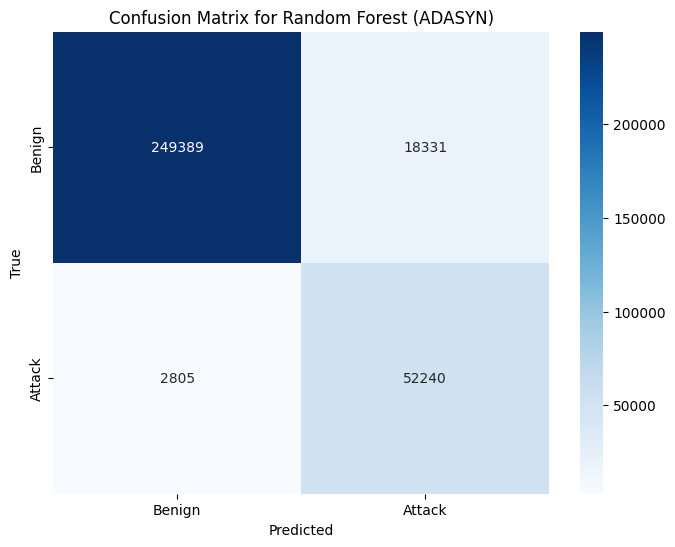

Metrics by Label (ADASYN):
                       Label  Accuracy  Method
0                     Benign  0.931529  ADASYN
1           DDOS attack-HOIC  0.997748  ADASYN
2     DDoS attacks-LOIC-HTTP  0.995232  ADASYN
3           DoS attacks-Hulk  0.999568  ADASYN
4   DoS attacks-SlowHTTPTest  1.000000  ADASYN
5             SSH-Bruteforce  0.999733  ADASYN
6             FTP-BruteForce  1.000000  ADASYN
7              Infilteration  0.151411  ADASYN
8      DoS attacks-GoldenEye  1.000000  ADASYN
9                        Bot  0.999478  ADASYN
10      DDOS attack-LOIC-UDP  1.000000  ADASYN
11     DoS attacks-Slowloris  0.990521  ADASYN
12          Brute Force -Web  0.909091  ADASYN
13          Brute Force -XSS  0.800000  ADASYN
14             SQL Injection  1.000000  ADASYN


In [44]:
# Predict and evaluate on the test set
rf_metrics["adasyn"] = test_metrics("Random Forest", rf_model_adasyn, "ADASYN", scaler_adasyn)

In [45]:
# Combine metrics into one DataFrame
combined_metrics_rf = pd.concat([rf_metrics["adasyn"][1], rf_metrics["original"][1], rf_metrics["random"][1], rf_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_rf = combined_metrics_rf.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_rf = accuracy_pivot_rf[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method:")
print(accuracy_pivot_rf)

Accuracy by Label and Method:
Method                    Original  Random Oversampling     SMOTE    ADASYN
Label                                                                      
Benign                    0.991958             0.975852  0.973734  0.931529
Bot                       0.997914             0.999478  0.999478  0.999478
Brute Force -Web          0.545455             0.545455  0.727273  0.909091
Brute Force -XSS          0.400000             0.600000  0.600000  0.800000
DDOS attack-HOIC          0.989029             0.993388  0.994623  0.997748
DDOS attack-LOIC-UDP      1.000000             1.000000  1.000000  1.000000
DDoS attacks-LOIC-HTTP    0.986997             0.988211  0.989511  0.995232
DoS attacks-GoldenEye     1.000000             1.000000  1.000000  1.000000
DoS attacks-Hulk          0.998056             0.998380  0.998596  0.999568
DoS attacks-SlowHTTPTest  1.000000             1.000000  1.000000  1.000000
DoS attacks-Slowloris     0.971564             0.976303  0

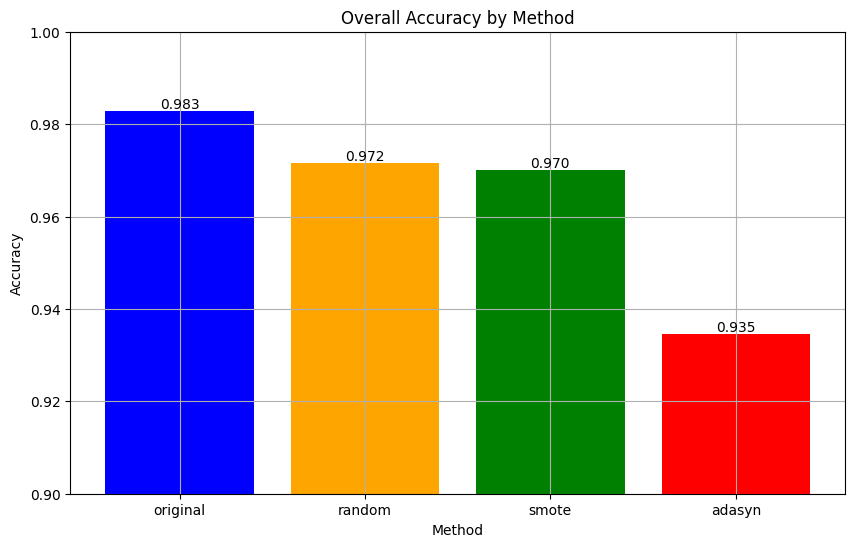

In [46]:
plot_overall_accuracy(rf_metrics)

### Adaboost

In [47]:
ada_metrics = {}

In [48]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(algorithm='SAMME')
ada_model.fit(scaler.transform(X_train), Y_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with Original Test Set Performance
Classification Report (Test AdaBoost (Original)):
              precision    recall  f1-score   support

           0     0.9663    0.9839    0.9750    267720
           1     0.9140    0.8330    0.8716     55045

    accuracy                         0.9582    322765
   macro avg     0.9401    0.9085    0.9233    322765
weighted avg     0.9574    0.9582    0.9574    322765

Accuracy: 0.958158412467275
Precision: 0.9573685394091846
Recall: 0.958158412467275
F1 Score: 0.9573774935315756
AUC: 0.9084568363222154


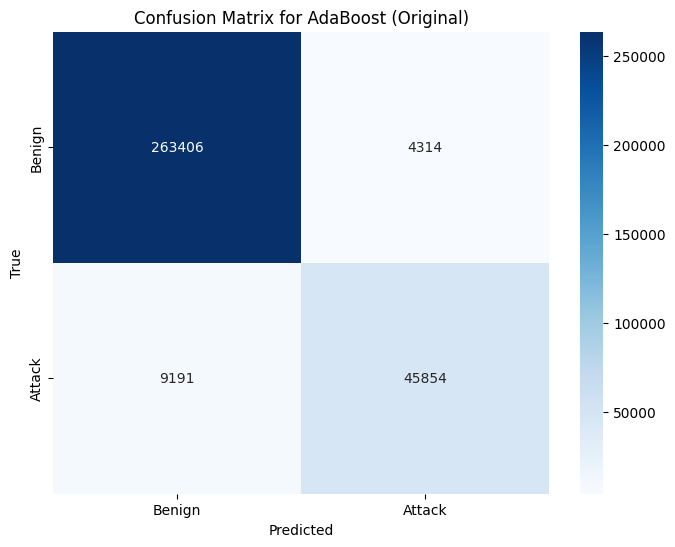

Metrics by Label (Original):
                       Label  Accuracy    Method
0                     Benign  0.983886  Original
1           DDOS attack-HOIC  0.957640  Original
2     DDoS attacks-LOIC-HTTP  0.923544  Original
3           DoS attacks-Hulk  0.974949  Original
4   DoS attacks-SlowHTTPTest  0.869922  Original
5             SSH-Bruteforce  0.980011  Original
6             FTP-BruteForce  0.874452  Original
7              Infilteration  0.036991  Original
8      DoS attacks-GoldenEye  0.501779  Original
9                        Bot  0.492524  Original
10      DDOS attack-LOIC-UDP  0.000000  Original
11     DoS attacks-Slowloris  0.497630  Original
12          Brute Force -Web  0.090909  Original
13          Brute Force -XSS  0.200000  Original
14             SQL Injection  0.000000  Original


In [49]:
# Predict and evaluate on the test set
ada_metrics["original"] = test_metrics("AdaBoost", ada_model, "Original", scaler)

In [50]:
ada_model_random = AdaBoostClassifier(algorithm='SAMME')
ada_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with Random Oversampling Test Set Performance
Classification Report (Test AdaBoost (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9897    0.8366    0.9068    267720
           1     0.5466    0.9577    0.6960     55045

    accuracy                         0.8573    322765
   macro avg     0.7681    0.8972    0.8014    322765
weighted avg     0.9141    0.8573    0.8708    322765

Accuracy: 0.8572831626725327
Precision: 0.9141432761392969
Recall: 0.8572831626725327
F1 Score: 0.8708068473290808
AUC: 0.8971857421926237


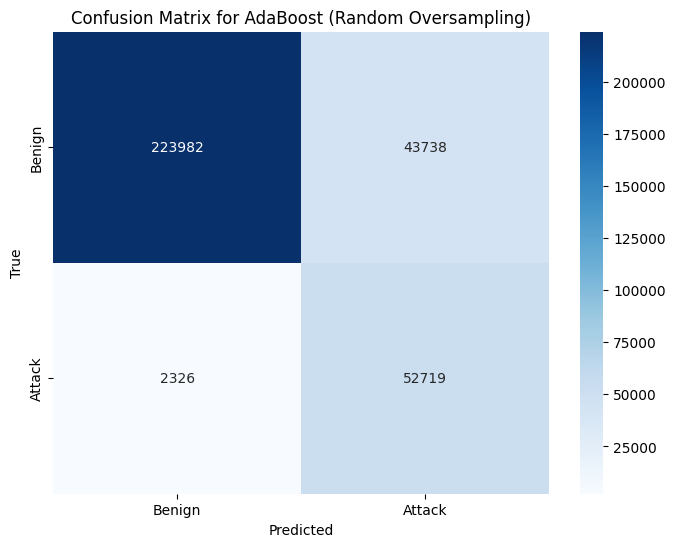

Metrics by Label (Random Oversampling):
                       Label  Accuracy               Method
0                     Benign  0.836628  Random Oversampling
1           DDOS attack-HOIC  1.000000  Random Oversampling
2     DDoS attacks-LOIC-HTTP  0.986304  Random Oversampling
3           DoS attacks-Hulk  0.999136  Random Oversampling
4   DoS attacks-SlowHTTPTest  1.000000  Random Oversampling
5             SSH-Bruteforce  1.000000  Random Oversampling
6             FTP-BruteForce  1.000000  Random Oversampling
7              Infilteration  0.331034  Random Oversampling
8      DoS attacks-GoldenEye  1.000000  Random Oversampling
9                        Bot  0.995480  Random Oversampling
10      DDOS attack-LOIC-UDP  1.000000  Random Oversampling
11     DoS attacks-Slowloris  1.000000  Random Oversampling
12          Brute Force -Web  1.000000  Random Oversampling
13          Brute Force -XSS  1.000000  Random Oversampling
14             SQL Injection  1.000000  Random Oversampling


In [51]:
# Predict and evaluate on the test set
ada_metrics["random"] = test_metrics("AdaBoost", ada_model_random, "Random Oversampling", scaler_random)

In [52]:
ada_model_smote = AdaBoostClassifier(algorithm='SAMME')
ada_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with SMOTE Test Set Performance
Classification Report (Test AdaBoost (SMOTE)):
              precision    recall  f1-score   support

           0     0.9892    0.8172    0.8950    267720
           1     0.5183    0.9567    0.6723     55045

    accuracy                         0.8410    322765
   macro avg     0.7537    0.8869    0.7837    322765
weighted avg     0.9089    0.8410    0.8570    322765

Accuracy: 0.8409554939352161
Precision: 0.9089018131038703
Recall: 0.8409554939352161
F1 Score: 0.8570188688361758
AUC: 0.8869248500171077


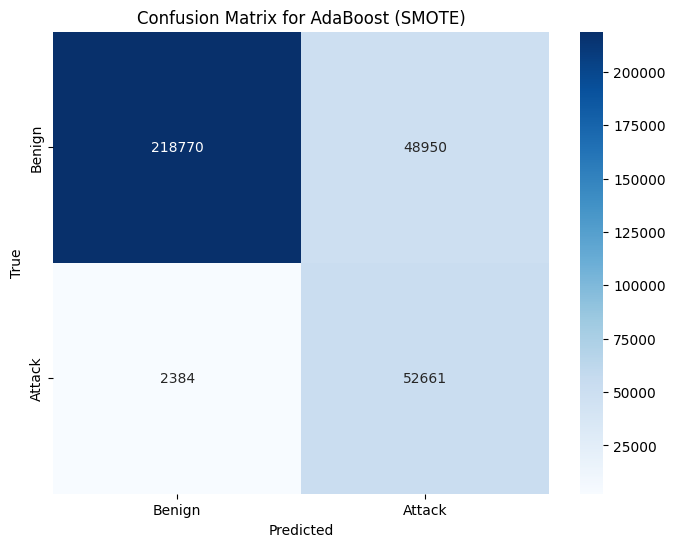

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.817160  SMOTE
1           DDOS attack-HOIC  1.000000  SMOTE
2     DDoS attacks-LOIC-HTTP  0.986564  SMOTE
3           DoS attacks-Hulk  0.999784  SMOTE
4   DoS attacks-SlowHTTPTest  1.000000  SMOTE
5             SSH-Bruteforce  1.000000  SMOTE
6             FTP-BruteForce  1.000000  SMOTE
7              Infilteration  0.334483  SMOTE
8      DoS attacks-GoldenEye  1.000000  SMOTE
9                        Bot  0.981919  SMOTE
10      DDOS attack-LOIC-UDP  1.000000  SMOTE
11     DoS attacks-Slowloris  1.000000  SMOTE
12          Brute Force -Web  1.000000  SMOTE
13          Brute Force -XSS  1.000000  SMOTE
14             SQL Injection  1.000000  SMOTE


In [53]:
# Predict and evaluate on the test set
ada_metrics["smote"] = test_metrics("AdaBoost", ada_model_smote, "SMOTE", scaler_smote)

In [54]:
ada_model_adasyn = AdaBoostClassifier(algorithm='SAMME')
ada_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

AdaBoostClassifier(algorithm='SAMME')

AdaBoost with ADASYN Test Set Performance
Classification Report (Test AdaBoost (ADASYN)):
              precision    recall  f1-score   support

           0     0.9529    0.8393    0.8925    267720
           1     0.5053    0.7981    0.6188     55045

    accuracy                         0.8323    322765
   macro avg     0.7291    0.8187    0.7557    322765
weighted avg     0.8765    0.8323    0.8458    322765

Accuracy: 0.8323021393273744
Precision: 0.876547317034483
Recall: 0.8323021393273744
F1 Score: 0.8458294017160278
AUC: 0.8187358191117472


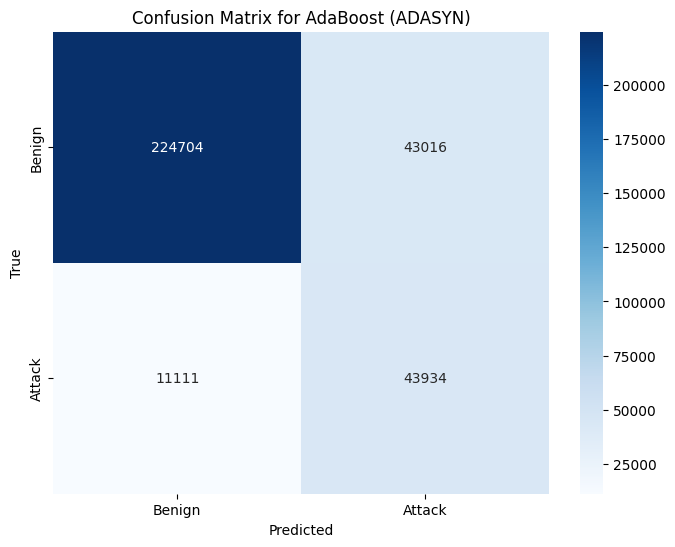

Metrics by Label (ADASYN):
                       Label  Accuracy  Method
0                     Benign  0.839325  ADASYN
1           DDOS attack-HOIC  0.999419  ADASYN
2     DDoS attacks-LOIC-HTTP  0.481276  ADASYN
3           DoS attacks-Hulk  0.996977  ADASYN
4   DoS attacks-SlowHTTPTest  1.000000  ADASYN
5             SSH-Bruteforce  1.000000  ADASYN
6             FTP-BruteForce  1.000000  ADASYN
7              Infilteration  0.318495  ADASYN
8      DoS attacks-GoldenEye  1.000000  ADASYN
9                        Bot  0.493220  ADASYN
10      DDOS attack-LOIC-UDP  1.000000  ADASYN
11     DoS attacks-Slowloris  1.000000  ADASYN
12          Brute Force -Web  0.818182  ADASYN
13          Brute Force -XSS  1.000000  ADASYN
14             SQL Injection  1.000000  ADASYN


In [55]:
# Predict and evaluate on the test set
ada_metrics["adasyn"] = test_metrics("AdaBoost", ada_model_adasyn, "ADASYN", scaler_adasyn)

In [56]:
# Combine metrics into one DataFrame
combined_metrics_ada = pd.concat([ada_metrics["adasyn"][1], ada_metrics["original"][1], ada_metrics["random"][1], ada_metrics["smote"][1]])

# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_ada = combined_metrics_ada.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_ada = accuracy_pivot_ada[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method (AdaBoost):")
print(accuracy_pivot_ada)

Accuracy by Label and Method (AdaBoost):
Method                    Original  Random Oversampling     SMOTE    ADASYN
Label                                                                      
Benign                    0.983886             0.836628  0.817160  0.839325
Bot                       0.492524             0.995480  0.981919  0.493220
Brute Force -Web          0.090909             1.000000  1.000000  0.818182
Brute Force -XSS          0.200000             1.000000  1.000000  1.000000
DDOS attack-HOIC          0.957640             1.000000  1.000000  0.999419
DDOS attack-LOIC-UDP      0.000000             1.000000  1.000000  1.000000
DDoS attacks-LOIC-HTTP    0.923544             0.986304  0.986564  0.481276
DoS attacks-GoldenEye     0.501779             1.000000  1.000000  1.000000
DoS attacks-Hulk          0.974949             0.999136  0.999784  0.996977
DoS attacks-SlowHTTPTest  0.869922             1.000000  1.000000  1.000000
DoS attacks-Slowloris     0.497630             

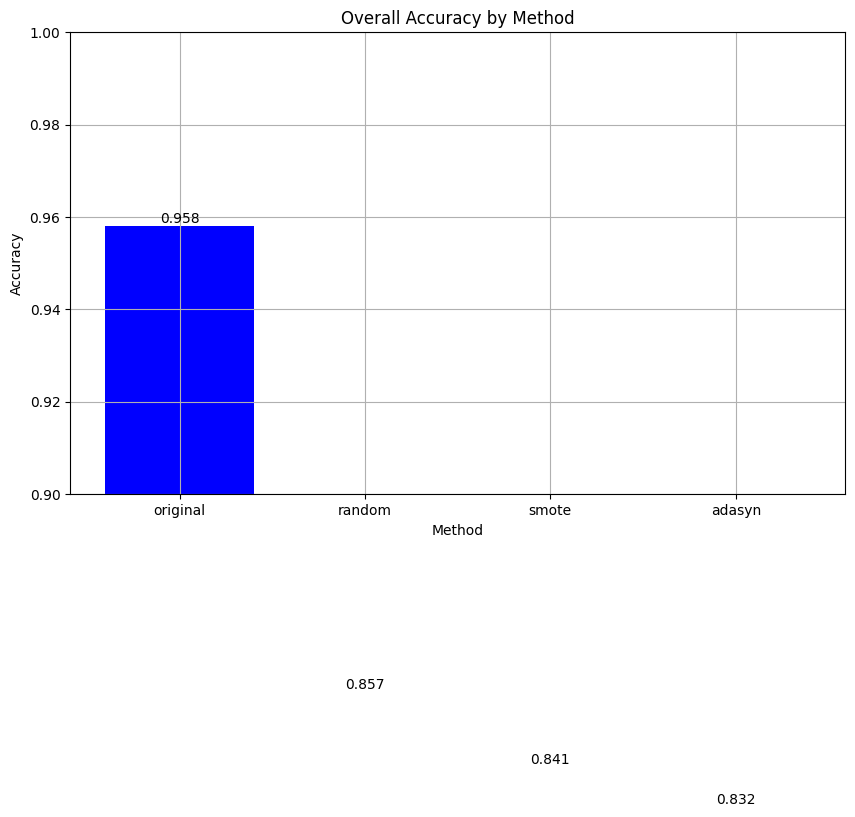

In [57]:
plot_overall_accuracy(ada_metrics)

### XGBoost

In [58]:
xgb_metrics = {}

In [59]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_jobs=-1)
xgb_model.fit(scaler.transform(X_train), Y_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with Original Test Set Performance
Classification Report (Test XGBoost (Original)):
              precision    recall  f1-score   support

           0     0.9872    0.9933    0.9902    267720
           1     0.9665    0.9372    0.9517     55045

    accuracy                         0.9838    322765
   macro avg     0.9769    0.9653    0.9710    322765
weighted avg     0.9837    0.9838    0.9837    322765

Accuracy: 0.983762179914179
Precision: 0.983655475338238
Recall: 0.983762179914179
F1 Score: 0.9836624283867066
AUC: 0.9652810119484841


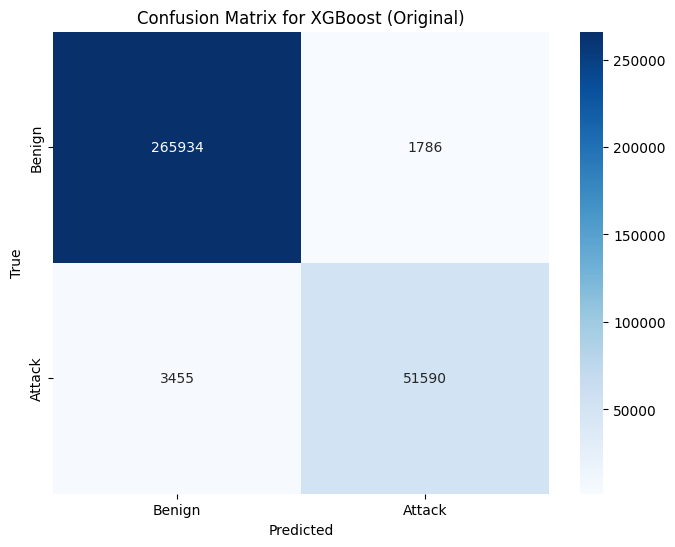

Metrics by Label (Original):
                       Label  Accuracy    Method
0                     Benign  0.993329  Original
1           DDOS attack-HOIC  0.996440  Original
2     DDoS attacks-LOIC-HTTP  0.979282  Original
3           DoS attacks-Hulk  0.999676  Original
4   DoS attacks-SlowHTTPTest  1.000000  Original
5             SSH-Bruteforce  1.000000  Original
6             FTP-BruteForce  1.000000  Original
7              Infilteration  0.023511  Original
8      DoS attacks-GoldenEye  0.998814  Original
9                        Bot  0.996871  Original
10      DDOS attack-LOIC-UDP  1.000000  Original
11     DoS attacks-Slowloris  0.914692  Original
12          Brute Force -Web  0.363636  Original
13          Brute Force -XSS  0.400000  Original
14             SQL Injection  0.000000  Original


In [60]:
# Predict and evaluate on the test set
# Original Dataset
xgb_metrics["original"] = test_metrics("XGBoost", xgb_model, "Original", scaler)

In [61]:
xgb_model_random = xgb.XGBClassifier(n_jobs=-1)
xgb_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with Random Oversampling Test Set Performance
Classification Report (Test XGBoost (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9902    0.9752    0.9826    267720
           1     0.8876    0.9531    0.9192     55045

    accuracy                         0.9714    322765
   macro avg     0.9389    0.9641    0.9509    322765
weighted avg     0.9727    0.9714    0.9718    322765

Accuracy: 0.9714126376775672
Precision: 0.9727028383818523
Recall: 0.9714126376775672
F1 Score: 0.9718117201171353
AUC: 0.9641216761758172


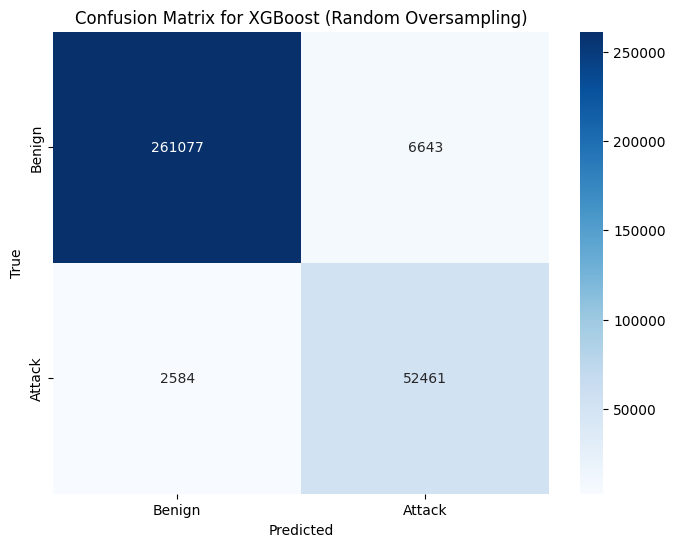

Metrics by Label (Random Oversampling):
                       Label  Accuracy               Method
0                     Benign  0.975187  Random Oversampling
1           DDOS attack-HOIC  0.998329  Random Oversampling
2     DDoS attacks-LOIC-HTTP  0.985697  Random Oversampling
3           DoS attacks-Hulk  0.999784  Random Oversampling
4   DoS attacks-SlowHTTPTest  1.000000  Random Oversampling
5             SSH-Bruteforce  1.000000  Random Oversampling
6             FTP-BruteForce  1.000000  Random Oversampling
7              Infilteration  0.254859  Random Oversampling
8      DoS attacks-GoldenEye  1.000000  Random Oversampling
9                        Bot  0.998435  Random Oversampling
10      DDOS attack-LOIC-UDP  1.000000  Random Oversampling
11     DoS attacks-Slowloris  0.985782  Random Oversampling
12          Brute Force -Web  0.636364  Random Oversampling
13          Brute Force -XSS  0.800000  Random Oversampling
14             SQL Injection  1.000000  Random Oversampling


In [62]:
# Predict and evaluate on the test set
# Random Oversampling
xgb_metrics["random"] = test_metrics("XGBoost", xgb_model_random, "Random Oversampling", scaler_random)

In [63]:
xgb_model_smote = xgb.XGBClassifier(n_jobs=-1)
xgb_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with SMOTE Test Set Performance
Classification Report (Test XGBoost (SMOTE)):
              precision    recall  f1-score   support

           0     0.9899    0.9828    0.9863    267720
           1     0.9193    0.9512    0.9350     55045

    accuracy                         0.9774    322765
   macro avg     0.9546    0.9670    0.9607    322765
weighted avg     0.9779    0.9774    0.9776    322765

Accuracy: 0.9774324973277771
Precision: 0.9778513988563949
Recall: 0.9774324973277771
F1 Score: 0.9775848417524753
AUC: 0.9670216661694708


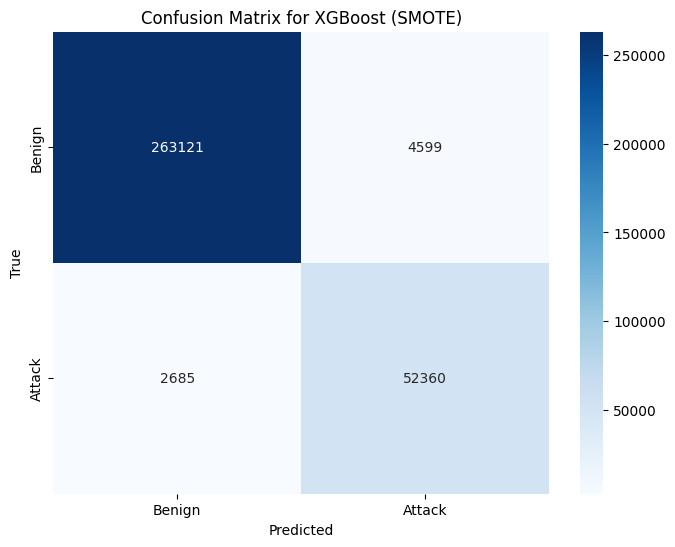

Metrics by Label (SMOTE):
                       Label  Accuracy Method
0                     Benign  0.982822  SMOTE
1           DDOS attack-HOIC  0.999055  SMOTE
2     DDoS attacks-LOIC-HTTP  0.982576  SMOTE
3           DoS attacks-Hulk  0.999784  SMOTE
4   DoS attacks-SlowHTTPTest  1.000000  SMOTE
5             SSH-Bruteforce  1.000000  SMOTE
6             FTP-BruteForce  1.000000  SMOTE
7              Infilteration  0.230721  SMOTE
8      DoS attacks-GoldenEye  1.000000  SMOTE
9                        Bot  0.998609  SMOTE
10      DDOS attack-LOIC-UDP  1.000000  SMOTE
11     DoS attacks-Slowloris  0.985782  SMOTE
12          Brute Force -Web  0.727273  SMOTE
13          Brute Force -XSS  1.000000  SMOTE
14             SQL Injection  0.500000  SMOTE


In [64]:
# Predict and evaluate on the test set
# SMOTE
xgb_metrics["smote"] = test_metrics("XGBoost", xgb_model_smote, "SMOTE", scaler_smote)

In [65]:
xgb_model_adasyn = xgb.XGBClassifier(n_jobs=-1)
xgb_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost with ADASYN Test Set Performance
Classification Report (Test XGBoost (ADASYN)):
              precision    recall  f1-score   support

           0     0.9892    0.9689    0.9789    267720
           1     0.8626    0.9484    0.9034     55045

    accuracy                         0.9654    322765
   macro avg     0.9259    0.9587    0.9412    322765
weighted avg     0.9676    0.9654    0.9661    322765

Accuracy: 0.9654268585503385
Precision: 0.9675762560643688
Recall: 0.9654268585503385
F1 Score: 0.966067678825433
AUC: 0.9586661700611769


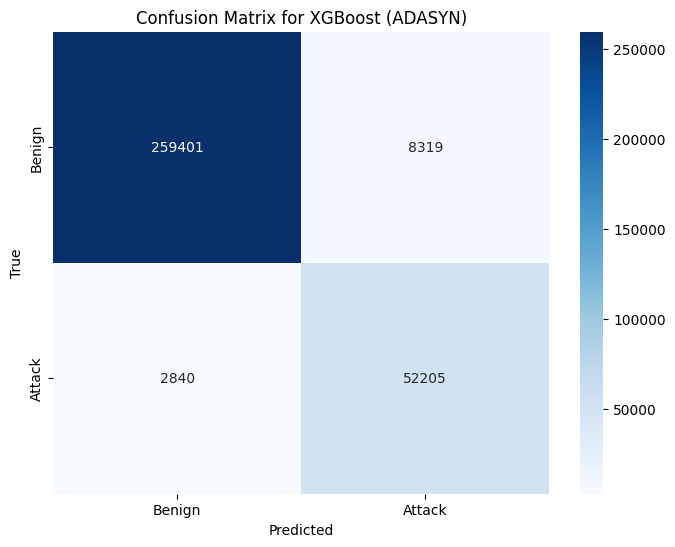

Metrics by Label (ADASYN):
                       Label  Accuracy  Method
0                     Benign  0.968926  ADASYN
1           DDOS attack-HOIC  0.999491  ADASYN
2     DDoS attacks-LOIC-HTTP  0.997053  ADASYN
3           DoS attacks-Hulk  1.000000  ADASYN
4   DoS attacks-SlowHTTPTest  1.000000  ADASYN
5             SSH-Bruteforce  1.000000  ADASYN
6             FTP-BruteForce  1.000000  ADASYN
7              Infilteration  0.125392  ADASYN
8      DoS attacks-GoldenEye  0.998814  ADASYN
9                        Bot  0.999652  ADASYN
10      DDOS attack-LOIC-UDP  1.000000  ADASYN
11     DoS attacks-Slowloris  0.990521  ADASYN
12          Brute Force -Web  0.727273  ADASYN
13          Brute Force -XSS  1.000000  ADASYN
14             SQL Injection  0.500000  ADASYN


In [66]:
# Predict and evaluate on the test set
# ADASYN
xgb_metrics["adasyn"] = test_metrics("XGBoost", xgb_model_adasyn, "ADASYN", scaler_adasyn)

In [67]:
# Combine metrics into one DataFrame
combined_metrics_xgb = pd.concat([xgb_metrics["adasyn"][1], xgb_metrics["original"][1], xgb_metrics["random"][1], xgb_metrics["smote"][1]])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot_xgb = combined_metrics_xgb.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot_xgb = accuracy_pivot_xgb[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method:")
print(accuracy_pivot_xgb)

Accuracy by Label and Method:
Method                    Original  Random Oversampling     SMOTE    ADASYN
Label                                                                      
Benign                    0.993329             0.975187  0.982822  0.968926
Bot                       0.996871             0.998435  0.998609  0.999652
Brute Force -Web          0.363636             0.636364  0.727273  0.727273
Brute Force -XSS          0.400000             0.800000  1.000000  1.000000
DDOS attack-HOIC          0.996440             0.998329  0.999055  0.999491
DDOS attack-LOIC-UDP      1.000000             1.000000  1.000000  1.000000
DDoS attacks-LOIC-HTTP    0.979282             0.985697  0.982576  0.997053
DoS attacks-GoldenEye     0.998814             1.000000  1.000000  0.998814
DoS attacks-Hulk          0.999676             0.999784  0.999784  1.000000
DoS attacks-SlowHTTPTest  1.000000             1.000000  1.000000  1.000000
DoS attacks-Slowloris     0.914692             0.985782  0

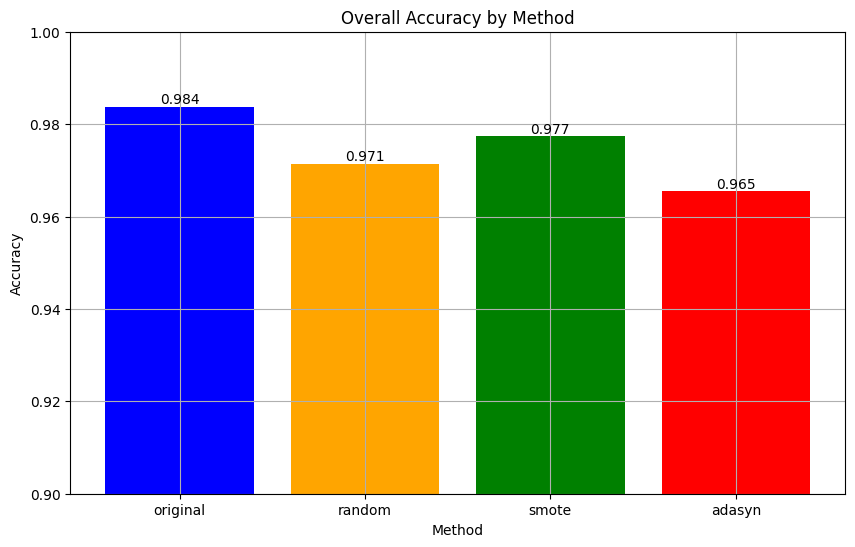

In [68]:
plot_overall_accuracy(xgb_metrics)